In [1]:
import pathlib
import numpy as np
import skimage
import plotly.graph_objects as go

from scipy.spatial import ConvexHull

import matplotlib.pyplot as plt
from matplotlib.path import Path as pltpath
from matplotlib.gridspec import GridSpec

In [2]:
import open3d as o3d
from copy import deepcopy

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# `def get_ref_color()`

In [3]:
from matplotlib.colors import ListedColormap

In [4]:
def get_ref_color():

    ref_color_folder = pathlib.Path('./pin_ref/')

    ref_color_rgb = []
    ref_color_hsv = {}

    for i in range(1,11):

        ref_img_path = ref_color_folder / f"{i}.png"

        ref_color_imarray = plt.imread( str(ref_img_path) )

        mask = ref_color_imarray[:,:,3] == 1

        ref_color_masked = ref_color_imarray[mask]

        ref_color_rgb.append(np.median(ref_color_masked[:,0:3], axis=0))
        ref_color_hsv[str(i)] = np.median(skimage.color.rgb2hsv(ref_color_masked[:,0:3]), axis=0)

    custom_colormap = ListedColormap(np.asarray(ref_color_rgb))

    return ref_color_hsv, custom_colormap

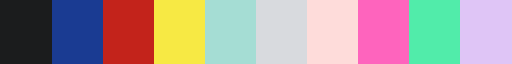

In [5]:
ref_color_hsv, custom_colormap = get_ref_color()
custom_colormap

In [6]:
ref_color_hsv

{'1': array([0.6111111 , 0.08333333, 0.11372549], dtype=float32),
 '2': array([0.62073493, 0.8206897 , 0.57254905], dtype=float32),
 '3': array([0.00803213, 0.8629442 , 0.7647059 ], dtype=float32),
 '4': array([0.15277779, 0.7258064 , 0.96862745], dtype=float32),
 '5': array([0.4732143 , 0.25112107, 0.8666667 ], dtype=float32),
 '6': array([0.6041667 , 0.03153153, 0.8745098 ], dtype=float32),
 '7': array([0.01010101, 0.14229248, 0.99607843], dtype=float32),
 '8': array([0.9032258 , 0.60392153, 0.99607843], dtype=float32),
 '9': array([0.42919388, 0.6547085 , 0.9254902 ], dtype=float32),
 '10': array([0.7558139 , 0.19591835, 0.9647059 ], dtype=float32)}

Get color and classify by distance threshold

In [8]:
sfm_pcd_folder = pathlib.Path(r'/home/crest/w/hwang_Pro/datasets/3DPotatoTwin/2_SfM/2_pcd')

# potato_id = '2R1-1'
potato_id = '3R1-3'

# def xxx
sfm_pcd_path = sfm_pcd_folder / f"{potato_id}/{potato_id}_30000.ply"
sfm_pcd = o3d.io.read_point_cloud( str(sfm_pcd_path) )

colors = np.asarray(sfm_pcd.colors)

colors_hsv = skimage.color.rgb2hsv(colors)

color_distance = abs(colors_hsv - ref_color_hsv[ potato_id.split('-')[-1] ]).sum(axis=1)

color_distance

array([0.67357565, 0.58876484, 0.45923845, ..., 0.56771113, 0.61430049,
       0.62311436])

In [9]:
color_distance.min()

0.18447293734346148

In [10]:
import matplotlib.colors as mcolors
import matplotlib.cm as mcm

In [11]:
# 定义一个Normalize对象，用于将数据值归一化到[0, 1]的范围
norm = mcolors.Normalize(vmin=np.min(color_distance), vmax=np.max(color_distance))

# 选择一个colormap
colormap = plt.cm.viridis

# 使用colormap和Normalize对象将数据值映射到颜色
color_array = colormap(norm(color_distance))

color_array

array([[0.192357, 0.403199, 0.555836, 1.      ],
       [0.220057, 0.343307, 0.549413, 1.      ],
       [0.260571, 0.246922, 0.522828, 1.      ],
       ...,
       [0.225863, 0.330805, 0.547314, 1.      ],
       [0.210503, 0.363727, 0.552206, 1.      ],
       [0.208623, 0.367752, 0.552675, 1.      ]])

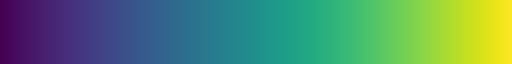

In [12]:
colormap

In [13]:
sfm_pcd_cm = deepcopy(sfm_pcd)

sfm_pcd_cm.colors = o3d.utility.Vector3dVector(color_array[:,0:3])

pin_idx = np.where(color_distance < 0.25)[0]

pin_pcd = sfm_pcd_cm.select_by_index(pin_idx)
pin_pcd.paint_uniform_color([1,0,0])

o3d.visualization.draw_geometries([sfm_pcd_cm, pin_pcd])
# o3d.visualization.draw_geometries([sfm_pcd_cm])

In [25]:
o3d.visualization.draw_geometries([sfm_pcd])

In [14]:
import seaborn as sns

/tmp/ipykernel_2402913/1917430192.py:1: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(color_distance, shade=True, color='green')
/home/crest/Applications/miniconda3/envs/potatoscan/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/crest/Applications/miniconda3/envs/potatoscan/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


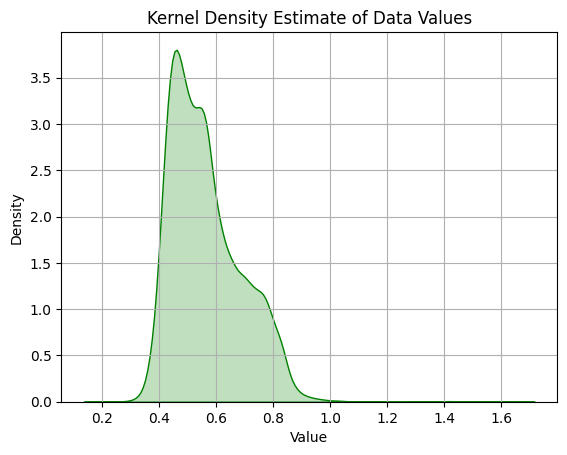

In [15]:
sns.kdeplot(color_distance, shade=True, color='green')
plt.title('Kernel Density Estimate of Data Values')
plt.xlabel('Value')
plt.ylabel('Density')
plt.grid(True)
plt.show()

Warp to funtions, try others

In [34]:
def get_hull_volume(o3d_pcd):
    pin_hull = o3d_pcd.compute_convex_hull()[0]
    hull_volume = pin_hull.get_volume() * 1000 ** 3 # mm3

    return hull_volume

def iter_hull_volume_by_thresh(sfm_pcd, color_distance_norm, thresh):

    pin_idx = np.where(color_distance_norm < thresh)[0]

    # calculate volume, if too large needs denoise
    pin_pcd = sfm_pcd.select_by_index(pin_idx)
    hull_volume = get_hull_volume(pin_pcd) # mm3

    return hull_volume, pin_idx

def hsv_ref_pin(sfm_pcd_folder, potato_id, ref_color_hsv, thresh=None, visualize=False):
    # get the sfm pcd
    sfm_pcd_path = sfm_pcd_folder / f"{potato_id}/{potato_id}_30000.ply"
    sfm_pcd = o3d.io.read_point_cloud( str(sfm_pcd_path) )

    colors = np.asarray(sfm_pcd.colors)

    colors_hsv = skimage.color.rgb2hsv(colors)

    
    # color_distance = abs(colors_hsv - ref_color_hsv[ potato_id.split('-')[-1] ]).sum(axis=1)
    color_distance_diff = abs(colors_hsv - ref_color_hsv[ potato_id.split('-')[-1] ])
    # hue -> circular distances
    need_hue_reverse = color_distance_diff[:,0] > 0.5
    color_distance_diff[need_hue_reverse, 0] = 1 - color_distance_diff[need_hue_reverse, 0]

    color_distance_weight = color_distance_diff * np.array([0.8,0.1,0.1])  # hsv weight
    color_distance = color_distance_weight.sum(axis=1)

    # 定义一个Normalize对象，用于将数据值归一化到[0, 1]的范围
    norm = mcolors.Normalize(vmin=np.min(color_distance), vmax=np.max(color_distance))

    color_distance_norm = norm(color_distance)

    # manually set the threshold
    if thresh is not None:
        hull_volume, pin_idx = iter_hull_volume_by_thresh(sfm_pcd, color_distance_norm, thresh)
    
    # looping the thresh to denoise
    else:
        thresh = 0.35
        hull_volume, pin_idx = iter_hull_volume_by_thresh(sfm_pcd, color_distance_norm, thresh)

        while hull_volume > 60:
            pin_pcd = sfm_pcd.select_by_index(pin_idx)
            pin_pcd_num = len(pin_pcd.points)
            print(f"Thresh={thresh} get pin convex hull volumn {hull_volume} > 60 with [{pin_pcd_num}] points, denoise first")
            keeped, keeped_idx = pin_pcd.remove_radius_outlier(nb_points=min(40, int(pin_pcd_num/20)), radius=0.005)

            denoised_volume = get_hull_volume(keeped)

            if denoised_volume > 60:  # still > 50 after denoising
                thresh -= 0.05

                if thresh <0:
                    raise ValueError("Threshold can not below 0")

                hull_volume, pin_idx = iter_hull_volume_by_thresh(sfm_pcd, color_distance_norm, thresh)
            else:
                hull_volume = denoised_volume
                pin_idx = pin_idx[keeped_idx]
                print(f"Stop at thresh={thresh} with hull volume = {hull_volume} after denoising")
                break
        else:
            print(f"Stop at thresh={thresh} with hull volume = {hull_volume}")

    # print(f"pin volume = {hull_volume}")
    # if hull_volume > 60: # larger than pin, must have noise
    #     keeped, keeped_idx = pin_pcd.remove_radius_outlier(nb_points=50, radius=0.005)

    #     pin_idx = pin_idx[keeped_idx]

    #     removed_pcd = pin_pcd.select_by_index(keeped_idx, invert=True)
    #     removed_pcd.paint_uniform_color([0,1,1])

    #     denoised_volume = sfm_pcd.select_by_index(pin_idx).compute_convex_hull()[0].get_volume()  * 1000 ** 3 
    #     print(f"pin convexhull volume denoised from {hull_volume} to {denoised_volume}")

    if visualize:
        # 选择一个colormap
        colormap = plt.cm.viridis

        # 使用colormap和Normalize对象将数据值映射到颜色
        color_array = colormap(norm(color_distance))
        sfm_pcd_cm = deepcopy(sfm_pcd)
        sfm_pcd_cm.colors = o3d.utility.Vector3dVector(color_array[:,0:3])

        # add offsets
        xyz = np.asarray(sfm_pcd_cm.points) + np.array([0.1, 0, 0])
        sfm_pcd_cm.points = o3d.utility.Vector3dVector(xyz)

        pin_pcd = sfm_pcd.select_by_index(pin_idx)
        if potato_id.split('-')[-1] == '3': # red pin
            pin_pcd.paint_uniform_color([0,1,0])
        else:
            pin_pcd.paint_uniform_color([1,0,0])
        

        o3d.visualization.draw_geometries([sfm_pcd, sfm_pcd_cm, pin_pcd], window_name=f"{potato_id} | thresh={thresh}")

    return pin_idx, sfm_pcd
        

In [184]:
pin_idx, sfm_pcd = hsv_ref_pin(sfm_pcd_folder, 'R3-9', ref_color_hsv, visualize=True)

Stop at thresh=0.35 with hull volume = 56.46652278364675


In [185]:
pin_idx, sfm_pcd = hsv_ref_pin(sfm_pcd_folder, 'R3-1', ref_color_hsv, visualize=True)

Stop at thresh=0.35 with hull volume = 23.672678227514094


In [190]:
pin_idx, sfm_pcd = hsv_ref_pin(sfm_pcd_folder, 'R3-3', ref_color_hsv, visualize=True)

Thresh=0.35 get pin convex hull volumn 96018.77215018909 > 60, denoise first
Thresh=0.3 get pin convex hull volumn 92337.8503708364 > 60, denoise first
Thresh=0.25 get pin convex hull volumn 66611.87525249117 > 60, denoise first
Thresh=0.2 get pin convex hull volumn 3900.371686427296 > 60, denoise first
Stop at thresh=0.2 with hull volume = 57.30333822858871 after denoising


In [187]:
pin_idx, sfm_pcd = hsv_ref_pin(sfm_pcd_folder, '2R1-1', ref_color_hsv, visualize=True)

Stop at thresh=0.35 with hull volume = 17.391274828099036


In [35]:
pin_idx, sfm_pcd = hsv_ref_pin(sfm_pcd_folder, '3R1-3', ref_color_hsv, visualize=True)

Thresh=0.35 get pin convex hull volumn 29695.337667221247 > 60 with [172] points, denoise first
Thresh=0.3 get pin convex hull volumn 61.39430494881979 > 60 with [162] points, denoise first
Stop at thresh=0.25 with hull volume = 52.984241819072615


In [172]:
for i in range(1, 11):
    pin_idx, sfm_pcd = hsv_ref_pin(sfm_pcd_folder, f'R3-{i}', ref_color_hsv, visualize=True)

Stop at thresh=0.35 with hull volume = 23.67267822751408
Stop at thresh=0.35 with hull volume = 52.90881284086653
Thresh=0.35 get pin convex hull volumn 96018.77215018909 > 60, decrease thresh to denoise
Thresh=0.3 get pin convex hull volumn 92337.85037083642 > 60, decrease thresh to denoise
Thresh=0.25 get pin convex hull volumn 66611.87525249118 > 60, decrease thresh to denoise
Thresh=0.2 get pin convex hull volumn 3900.371686427297 > 60, decrease thresh to denoise
Stop at thresh=0.15000000000000002 with hull volume = 39.94922563771741
Thresh=0.35 get pin convex hull volumn 109192.85301987654 > 60, decrease thresh to denoise
Thresh=0.3 get pin convex hull volumn 63049.352429809034 > 60, decrease thresh to denoise
Thresh=0.25 get pin convex hull volumn 48557.098499598935 > 60, decrease thresh to denoise
Thresh=0.2 get pin convex hull volumn 14095.329313550943 > 60, decrease thresh to denoise
Stop at thresh=0.15000000000000002 with hull volume = 47.46596506283321
Thresh=0.35 get pin co

In [192]:
for i in range(1, 11):
    pin_idx, sfm_pcd = hsv_ref_pin(sfm_pcd_folder, f'2R1-{i}', ref_color_hsv, visualize=True)

Stop at thresh=0.35 with hull volume = 17.391274828098997
Stop at thresh=0.35 with hull volume = 38.303704575832406
Thresh=0.35 get pin convex hull volumn 70623.95291679646 > 60, denoise first
Thresh=0.3 get pin convex hull volumn 46642.469341586904 > 60, denoise first
Stop at thresh=0.25 with hull volume = 45.684075484683774
Thresh=0.35 get pin convex hull volumn 127269.12240034944 > 60, denoise first
Thresh=0.3 get pin convex hull volumn 84256.18204774515 > 60, denoise first
Thresh=0.25 get pin convex hull volumn 14512.264995643869 > 60, denoise first
Thresh=0.2 get pin convex hull volumn 882.9019884719562 > 60, denoise first
Stop at thresh=0.2 with hull volume = 55.46160449633374 after denoising
Stop at thresh=0.35 with hull volume = 31.587939667873695
Stop at thresh=0.35 with hull volume = 39.165746554216675
Thresh=0.35 get pin convex hull volumn 62210.62812811455 > 60, denoise first
Thresh=0.3 get pin convex hull volumn 12284.732459672145 > 60, denoise first
Thresh=0.25 get pin co

In [178]:
for i in range(1, 11):
    pin_idx, sfm_pcd = hsv_ref_pin(sfm_pcd_folder, f'4R3-{i}', ref_color_hsv, visualize=True)

Thresh=0.35 get pin convex hull volumn 3906.2182390689845 > 60, decrease thresh to denoise
Thresh=0.3 get pin convex hull volumn 3785.7649448090665 > 60, decrease thresh to denoise
Thresh=0.25 get pin convex hull volumn 1018.9776620090993 > 60, decrease thresh to denoise
Thresh=0.2 get pin convex hull volumn 998.7098012570738 > 60, decrease thresh to denoise
Thresh=0.15000000000000002 get pin convex hull volumn 980.9376099067904 > 60, decrease thresh to denoise
Thresh=0.10000000000000002 get pin convex hull volumn 718.3396602852837 > 60, decrease thresh to denoise
Stop at thresh=0.05000000000000002 with hull volume = 19.96522392326387
Stop at thresh=0.35 with hull volume = 52.44878984106247
Thresh=0.35 get pin convex hull volumn 98349.09779929844 > 60, decrease thresh to denoise
Thresh=0.3 get pin convex hull volumn 69809.7480554459 > 60, decrease thresh to denoise
Thresh=0.25 get pin convex hull volumn 23760.572657633344 > 60, decrease thresh to denoise
Thresh=0.2 get pin convex hull 

In [191]:
pin_idx, sfm_pcd = hsv_ref_pin(sfm_pcd_folder, '4R3-1', ref_color_hsv, visualize=True)

Thresh=0.35 get pin convex hull volumn 3906.218239068983 > 60, denoise first
Thresh=0.3 get pin convex hull volumn 3785.7649448090665 > 60, denoise first
Thresh=0.25 get pin convex hull volumn 1018.977662009099 > 60, denoise first
Thresh=0.2 get pin convex hull volumn 998.7098012570738 > 60, denoise first
Thresh=0.15000000000000002 get pin convex hull volumn 980.9376099067904 > 60, denoise first
Thresh=0.10000000000000002 get pin convex hull volumn 718.3396602852836 > 60, denoise first
Stop at thresh=0.10000000000000002 with hull volume = 46.04120213020337 after denoising
